In [26]:
import pandas as pd
import geopandas as gp

#!pip install spint
import pysal
import spint
from spint import Gravity
from spint import Production 
from spint import Attraction 
from spint import Doubly

#!pip install pygam
import pygam
from pygam import PoissonGAM, s, te, l, f
from pygam.core import Core, nice_repr
from pygam.utils import isiterable, check_param, flatten, gen_edge_knots, b_spline_basis, tensor_product
from pygam.penalties import PENALTIES, CONSTRAINTS
from pygam import terms
from pygam.terms import Term, LinearTerm

import numpy as np
from sklearn.linear_model import LinearRegression, PoissonRegressor

#!pip install statsmodels
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

,Unnamed: 0,Origin,Destination,Data,Oi,Dj,Dij
0,0,AT11,AT11,0,4016,5146,1.000000e-300
1,1,AT11,AT12,1131,4016,25741,1.030018e+02
2,2,AT11,AT13,1887,4016,26980,8.420467e+01
3,3,AT11,AT21,69,4016,4117,2.208119e+02
4,4,AT11,AT22,738,4016,8634,1.320075e+02


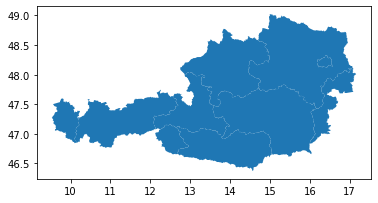

In [3]:
austria_shp = gp.read_file('Data/austria.shp')
austria_shp.plot()
austria = pd.read_csv('Data/austria.csv')
austria.head()#81

In [4]:
# format the data into arrays.
austria = austria[austria['Origin'] != austria['Destination']] #intra-zonal ﬂows have been excluded
flows = austria['Data'].values #the number of ﬂows between i and j
Oi = austria['Oi'].values 
Dj = austria['Dj'].values 
Dij = austria['Dij'].values 
Origin = austria['Origin'].values 
Destination = austria['Destination'].values

ln_Oi = np.log(austria['Oi'].values) #emissiveness of origin
ln_Wj = np.log(austria['Dj'].values) #attraction of destination
ln_Dij = np.log( austria['Dij'].values) #distance

In [5]:
#unconstrained gravity model
gravity = Gravity(flows, Oi, Dj, Dij, 'pow') 

In [6]:
gravity.params

array([-0.85755469,  0.70317833,  0.7376105 , -1.05939577])

Backfitting GAM and PoissonGAM with Golden Selection Search in CD Model

In [11]:
# calculate the Aij and AIC values given a sigma value
def aic_func(sigma):
    
    #calculate the Aij
    Aj = sum(Dj* (Dij**sigma))
    Aij = Aj - Dj* (Dij**sigma)
    ln_Aij = np.log(Aij)
    X = sm.add_constant(np.column_stack((ln_Oi, ln_Wj, ln_Dij, ln_Aij)))# so that the glm will estimate a constant
    
    #fit the model
    mod = OLS(flows, X).fit()#sm.GLM(flows, X, family=sm.families.Poisson(),).fit()
     
    #result dictonary
    result_dict = dict()
    result_dict['beta'] = mod.params[2]
    result_dict['delta'] = mod.params[3]
    result_dict['aic'] = mod.aic
    result_dict['partial_ress_beta'] = sum(flows - np.mean(flows)- mod.params[0] - mod.params[1]*ln_Oi-mod.params[2]*ln_Wj-mod.params[4]*ln_Aij)
    result_dict['partial_ress_delta'] = sum(flows - np.mean(flows) - mod.params[0]- mod.params[1]*ln_Oi-mod.params[2]*ln_Wj-mod.params[3]*ln_Dij) 
    #result_dict['mod'] = mod

    return result_dict 

In [13]:
# use golden search method with AIC and partial residuals as the criterion
# refer to the codes from search.py to implement golden search

# initilize the sigma values given the min and max value of sigma
sigma_a = -10 # the initilized MIN value of sigma
sigma_c = 5 # the initilized MAX value of sigma
step = 1 - 0.618 # following the book so far
sigma_b = sigma_a + step * np.abs(sigma_c - sigma_a)
sigma_d = sigma_c - step * np.abs(sigma_c - sigma_a)
    
#other initilization
tol = 1e-8 # a thereshold to decide whether f(d) = aic_func(d) stops changing
diff = np.inf # store the diff between different f(d)
opt_aic = np.inf # store the AIC value based on the optimal sigma value
aic_sigma_dict = dict() # store the sigma value and the aic value correpsondingly

#temporarily not consider the situation where we can't converge eventually
#max_iter = 100 
#iters = 0 

ptrs_beta0 = 0
ptrs_delta0 = 0
ptrs_beta_list = []
ptrs_delta_list = []
ptrs_beta_list.append(ptrs_beta0) # store all partial resdiduals
ptrs_delta_list.append(ptrs_delta0)

while (diff > tol or diff_b > tol or diff_d > tol) :# and (iters <= max_iter)

    aic_b = aic_func(sigma_b)['aic']
    aic_d = aic_func(sigma_d)['aic']
            
    if aic_b <= aic_d: #discard the old c, b<d<c
        opt_sigma = sigma_b
        sigma_c = sigma_d
        sigma_d = sigma_b
        sigma_b = sigma_a + step * np.abs(sigma_c - sigma_a)
            

    else: # discard the old a, a<b<d
        opt_sigma = sigma_d
        sigma_a = sigma_b
        sigma_b = sigma_d
        sigma_d = sigma_c - step * np.abs(sigma_c - sigma_a)
                   
    opt_sigma = np.round(opt_sigma, 3) 
        
    # the aic_b stores the last aic_d so the diff is the difference between the two successive values of f(d)
    diff = np.abs(aic_b - aic_d)
    
    ptrs_beta_list.append(aic_func(opt_sigma)['partial_ress_beta'])
    ptrs_delta_list.append(aic_func(opt_sigma)['partial_ress_delta'])
    
    diff_b = np.abs(ptrs_beta_list[-1] - ptrs_beta_list[-2])
    diff_d = np.abs(ptrs_delta_list[-1] - ptrs_delta_list[-2])
    #iters += 1

In [14]:
opt_sigma

-4.421

In [16]:
Aj = sum(Dj* (Dij**opt_sigma))
Aij = Aj - Dj* (Dij**opt_sigma)
ln_Aij = np.log(Aij)
X = sm.add_constant(np.column_stack((ln_Oi, ln_Wj, ln_Dij, ln_Aij)))
sm.GLM(flows, X, family=sm.families.Poisson(),).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6400.5
Date:                Mon, 29 Nov 2021   Deviance:                       12220.
Time:                        19:48:26   Pearson chi2:                 1.18e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2856      0.185    -23.158      0.000      -4.648      -3.923
x1             0.6455      0.006    106.625      0.000       0.634       0.657
x2             0.6765      0.006    116.577      0.000       0.665       0.688
x3            -0.9052      0.010    -92.476      0.000      -0.924      -0.886
x4            -0.6286      0.028    -22.377      0.000      -0.684      -0.574
==============================================================================
"""

------------------------------------------------------------------------------------------------------------------------

create the method `sa()` to get the Aij array

In [23]:
#spatial accessibility
def sa(m, d, sigma_min = -10, sigma_max = 0, step = 0.382, tol = 1e-8):
    
    def aic_func(sigma):
        #calculate different aic value with different sigma values
        
        #calculate the Aij
        Aj = sum(m* (d**sigma))
        Aij = Aj - m* (d**sigma)
        ln_Aij = np.log(Aij)
    
        X = np.column_stack((ln_Oi, ln_Wj, ln_Dij, ln_Aij))
        mod = OLS(flows, add_constant(X)).fit()
        # use ordinary least square
        # mod = sm.GLM(flows, X, family=sm.families.Poisson(),).fit()
        
        return mod.aic
    
    def find_opt_sigma(sigma_a = sigma_min, sigma_c = sigma_max, step = step, tol = tol):
        sigma_b = sigma_min + step * np.abs(sigma_max - sigma_min)
        sigma_d = sigma_max - step * np.abs(sigma_max - sigma_min)
        
        diff = np.inf
        opt_sigma = np.inf
    
        while (diff > tol) :# and (iters <= max_iter)
            
            aic_b = aic_func(sigma_b)
            aic_d = aic_func(sigma_d)
            
            if aic_b <= aic_d: #discard the old c, b<d<c
                opt_sigma = sigma_b
                sigma_c = sigma_d
                sigma_d = sigma_b
                sigma_b = sigma_a + step * np.abs(sigma_c - sigma_a)
            
            else: # discard the old a, a<b<d
                opt_sigma = sigma_d
                sigma_a = sigma_b
                sigma_b = sigma_d
                sigma_d = sigma_c - step * np.abs(sigma_c - sigma_a)
            
            diff = np.abs(aic_b - aic_d)      
            opt_sigma = np.round(opt_sigma, 3) 

        return opt_sigma
    
    opt_sigma = find_opt_sigma()
    Aj = sum(m * (d ** opt_sigma))
    Aij = Aj - m * (d ** opt_sigma)
    ln_Aij = np.log(Aij)
    
    return ln_Aij

In [24]:
X_ = np.column_stack((np.log(Oi), np.log(Dj), np.log(Dij), sa(Dj, Dij)))

mod_gam = PoissonGAM( l(0) + l(1) + l(2) + l(3),  fit_intercept = True).fit(X_, flows)
mod_gam.coef_

array([ 0.64549418,  0.67648627, -0.90520242, -0.62843556, -4.28490387])

-----------------------------------------------------------------------------------------------------------------------

Extend Terms Class in pygam package

In [27]:
#step 1: convert ln_dkj and ln_mk as dkj and mk
#step 2: find optimal sigma with golden selection
#step 3: calculate and return Aij column

class SpatialSmoother(LinearTerm): 
    def __init__(self, feature_m, feature_d, lam=0.6, penalties='auto', verbose=False,
                 sigma_min = -10, sigma_max = 0, step = 0.382, tol = 1e-8):
        
        self._name = 'spatial_smoother'
        self._minimal_name = 'ss'
        opt_sigma = np.inf
        
        super(SpatialSmoother, self).__init__(
            feature = feature_m, lam = lam, penalties = penalties,verbose = verbose)
        self._exclude += ['fit_splines', 'fit_linear', 'dtype', 'constraints']
        
    @property
    def n_coefs(self):
        """Number of coefficients contributed by the term to the model
        """
        return 1
    
    def optimal_sigma(): 
        
        return opt_sigma
    
    def compile(self, X, verbose=False):
        if self.feature >= X.shape[1]:
            raise ValueError('term requires feature {}, '\
                             'but X has only {} dimensions'\
                             .format(self.feature, X.shape[1]))

        self.edge_knots_ = gen_edge_knots(X[:, self.feature],
                                          self.dtype,
                                          verbose=verbose)
        return self
    
    def build_columns(self, X, y, verbose=False):
        
        def aic_func(sigma, m = exp(X[:,self.feature_m]), d = exp(X[:,self.feature_d]) , X = X, y = y):
            #calculate the Aij
            Aj = sum(m* (d**sigma))
            Aij = Aj - m* (d**sigma)
            ln_Aij = np.row_stack(log(Aij))
        
            X_new = np.append(X, ln_Aij, 1)
            mod = OLS(flows, add_constant(X_new)).fit()
            #mod = sm.GLM(flows, X, family=sm.families.Poisson(),).fit()
        
            return mod.aic
    
        def find_opt_sigma(sigma_a = self.sigma_min, sigma_c = self.sigma_max, step = self.step, tol = self.tol):
            sigma_b = sigma_min + step * np.abs(sigma_max - sigma_min)
            sigma_d = sigma_max - step * np.abs(sigma_max - sigma_min)
        
            diff = np.inf
            #opt_sigma = np.inf            
            while (diff > tol) :# and (iters <= max_iter)
                aic_b = aic_func(sigma_b)
                aic_d = aic_func(sigma_d)
                   
                if aic_b <= aic_d: #discard the old c, b<d<c
                    opt_sigma = sigma_b
                    sigma_c = sigma_d
                    sigma_d = sigma_b
                    sigma_b = sigma_a + step * np.abs(sigma_c - sigma_a)
            
                else: # discard the old a, a<b<d                    
                    opt_sigma = sigma_d
                    sigma_a = sigma_b
                    sigma_b = sigma_d
                    sigma_d = sigma_c - step * np.abs(sigma_c - sigma_a)
            
                diff = np.abs(aic_b - aic_d)      
                opt_sigma = np.round(opt_sigma, 3) 

            return opt_sigma

        Aj = sum(exp(X[:,self.feature_m]) * (exp(X[:,self.feature_d]) ** find_opt_sigma()))
        Aij = Aj - exp(X[:,self.feature_m]) * (exp(X[:,self.feature_d]) ** find_opt_sigma())
        ln_Aij = log(Aij)

        return  np.rowstack(ln_Aij)

    #def ss(feature_m, feature_k):
    #return SpatialSmoother(feature_m, feature_k)

In [28]:
X = np.column_stack((ln_Oi, ln_Wj, ln_Dij))
mod_gam = PoissonGAM(l(0) + l(1) + l(2) + SpatialSmoother(1, 2),  fit_intercept = True).fit(X, flows)
mod_gam.coef_

array([ 0.70317694,  0.73760879, -1.05938152, -0.85759029])